___

<a href='https://github.com/eliasmelul/'> <img src='https://s3.us-east-2.amazonaws.com/wordontheamazon.com/NoMargin_NewLogo.png' style='width: 15em;' align='right' /></a>
# Finance with Python
### Monte Carlo Simulations
___
<h4 align="right">by Elias Melul, Data Scientist </h4> 

___



In this notebook, we introduce how to use Monte Carlo simulations for forecasting future stock prices.

$$
{Price Today}={Price Yesterday * e^r}
$$

* We know yesterday's price. 

* We want to predict today's price. 

* What we do not know is the rate of return, r, of the share price between yesterday and today. 

This is where the Monte Carlo simulation comes in! But first, how do we compute the return?

### Brownian Motion

Brownian motion will be the main driver for estimating the return. It is a stochastic process used for modeling random behavior over time. For simplicity, we will use regular brownian motion, instead of the Geometric Brownian Motion, which is more common and less questionable in stock pricing applications.

**Brownian Motion** has two main main components:
1. Drift - the direction that rates of returns have had in the past. That is, the expected return of the stock.
$$
{Drift} = ({mean} - \frac{1}{2} {Var})
$$

    Why do we multiply the variance by 0.5? Because historical values are eroded in the future.
    

2. Volatility -  random variable. This is the historical volatility multiplied by a random, standard normally distributed variable.

$$
{Volatility} = {Std.Dev. * Z([Rand(0;1)])}
$$

Therefore, our asset pricing equation ends up looking like this:

$$
{Price Today}={Price Yesterday * e^{mean-\frac{1}{2}{Var} + Std.Dev * Z([Rand(0;1)])}}
$$



This technique will be used for every day into the future you want to predict, and for however many trials the monte carlo simulation will run!

---

First, import required libraries.

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
# import plotly as py
# import plotly.graph_objs as go
# import cufflinks
# cufflinks.go_offline(connected=True)
#init_notebook_mode(connected=True)

%matplotlib inline

Import data for one or multiple stocks from a specified date until the last available data. Data source: yahoo finance.

For this, it's better if we define a function that imports stock(s) daily data for any publicly traded company as defined by the user starting at a user-defined date until today. We will use the Adjusted Close price.

In [2]:
def import_stock_data(tickers, start = '2010-1-1'):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [3]:
data = import_stock_data(['PG'])

Then, we compute the logarithmic returns of the data.

In [4]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [5]:
log_return = log_returns(data)

We also create a function to compute the simple returns.

In [6]:
def simple_returns(data):
    return ((data/data.shift(1))-1)

## CAPM and Sharpe

Before we jump into Monte Carlo Simulations, we would like to report some statistics with it, including the Beta and Sharpe Ratio of the stock, compared to the _market portfolio_. To understand these metrics, we first must understand the underlying concepts of the _Capital Asset Pricing Model,_ starting with the _market portfolio_.

* The market portfolio is the theoretical combination of all possible investments in the world. However, there is no such thing as a market portfolio. We approximate it with a stock market index. In our case, we use the S&P500, but you can specify any index you want to!

* We also note that there is no such thing as a risk-free asset. We will use a 10-year US government bond yield of 2.5% instead.

* The equity premium is the difference between the expected return of the market and the risk-free asset. This value is typically between 4.5 and 5.5%. We will use 5%.

We use the _market portfolio_ to compute the Beta, the CAPM expected return, and the Sharpe Ratio of a stock.
1. **Beta**: measures the market risk that cannot be avoided through diversification. This is the relationship between the stock and the market portfolio. In other words, it is a measure of how much risk the investment will add to a portfolio that looks like the market.
##### $$ 
\beta_{pg} = \frac{\sigma_{pg,m}}{\sigma_{m}^2}
$$

    When beta = 0, it means that there's no relationship.
    
    When beta < 1, it means that the stock is defensive (less prone to high highs and low lows)
    
    When beta > 1, it means that the stock is aggresive (more prone to high highs and low lows)
    
    
2. **Expected Return CAPM**: calculates the expected return of a security adjusted to the risk taken. This equates to the return expected from taking the extra risk of purchasing this security.
##### $$
\overline{r_{pg}} = r_f + \beta_{pg}(\overline{r_{m}} - r_f) 
$$

3. **Sharpe Ratio**: measures the performance of a security compared to a risk-free asset, after adjusting for its risk.
##### $$
Sharpe = \frac{\overline{r_{pg}} - r_f}{\sigma_{pg}}
$$
    When Sharpe > 1, GOOD risk-adjusted returns
    
    When Sharpe > 2, VERY GOOD risk-adjusted returns
    
    When Sharpe > 3, EXCELLENT risk-adjusted returns
    

In [7]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    market_data = import_stock_data(mark_ticker, start)
    data = data.merge(market_data, left_index=True, right_index=True)
    return data

In [8]:
def beta_sharpe(data, mark_ticker = "^GSPC", start='2010-1-1', riskfree = 0.025, riskpremium = 0.05):
    # Beta
    dd = market_data_combination(data, mark_ticker, start)
    log_ret = log_returns(dd)
    covar = log_ret.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    mrk_var = log_ret.iloc[:,-1].var()*252
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * riskpremium)
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [9]:
beta_sharpe(data)

,Beta,STD,CAPM,Sharpe
PG,0.58955,0.171549,0.054478,0.171831


**Brownian Motion**

Now that we have our returns, we can compute the brownian motion, as explained in the introduction.
1. Calculate the drift
2. Calculate the variance
3. Calculate the daily returns based on the drift and variance

In [10]:
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [11]:
drift_calc(data)

array([0.00031047])

We calculated the drift above, but now, we must calculate the daily returns for the data. There are things to consider:
1. How many days into the future will we predict? (How many rows)
2. How many iterations of these predictions will we compute? (How many columns)

This generates the daily returns (not prices!) for each day into the future for each iteration (simulation) based on a normal distribution.

In [12]:
def daily_returns(data, days, iterations, return_type='log'):
    ft = drift_calc(data, return_type)
    if return_type == 'log':
        try:
            stv = log_returns(data).std().values
        except:
            stv = log_returns(data).std()
    elif return_type=='simple':
        try:
            stv = simple_returns(data).std().values
        except:
            stv = simple_returns(data).std()    
            
    dr = np.exp(ft + stv * norm.ppf(np.random.rand(days, iterations)))
    return dr

In [13]:
dr = daily_returns(data, 100, 50)

**Note**: This next function is used to calculate the probability of a stock having a higher price or higher returns than specified over the period defined. 

In [14]:
def probs_find(predicted, higherthan, on = 'value'):
    if on == 'return':
        predicted0 = predicted.iloc[0,0]
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
        less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
    elif on == 'value':
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    else:
        print("'on' must be either value or return")
    return (len(over)/(len(over)+len(less)))

Example: We would like to find out the probability that our investment in PG will breakeven or make a profit over the course of a year (financial year is about 252 days). There are two ways we can do this:
1. Returns = 0
2. Final stock price = initial stock price ($44.05 - Jan 1st 2010, the first data point)

So, with the simulation predicted values, we will predict said probabilities.

---

First, however, we must run the simulation! How does it work?

1. Calculate the daily returns for every day and every iteration (simulation) of the data. 
2. Creates an equally large matrix of size [days x iteration] full of zeroes.
3. Input the last stock price value in the first row (day 0) of the "empty" matrix (part 2). This is our starting point.
4. Calculate "today's price" based on yesterday's multiplied by the daily return generated. That is, multiply the daily return generated for every simulation with the stock price calculated for the previous day (the previous row) for every simulation.

Does that sounds familiar? The fourth step multiplies the daily returns with the price of the stock of the previous day!

In [15]:
def simulate_mc(data, days, iterations, return_type='log', plot=True):
    # Generate daily returns
    returns = daily_returns(data, days, iterations, return_type)
    # Create empty matrix
    price_list = np.zeros_like(returns)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for t in range(1,days):
        price_list[t] = price_list[t-1]*returns[t]
    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(price_list).iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
    
    #CAPM and Sharpe Ratio
    
    # Printing information about stock
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)
    print(f"Days: {days-1}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
    print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
          
    return pd.DataFrame(price_list)

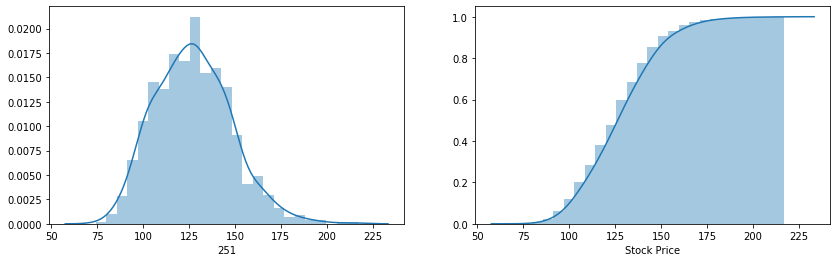

PG
Days: 251
Expected Value: $127.21
Return: 9.35%
Probability of Breakeven: 0.701


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,115.309998,115.309998,115.309998,115.309998,115.309998,115.309998,115.309998,115.309998,115.309998,115.309998,...,115.309998,115.309998,115.309998,115.309998,115.309998,115.309998,115.309998,115.309998,115.309998,115.309998
1,115.282838,115.220158,113.993805,115.389641,115.624688,115.630972,113.176412,114.409079,116.424126,118.275580,...,113.134989,114.634769,113.167117,113.597200,113.540136,116.580780,116.686569,115.021703,113.779193,117.602242
2,115.975809,115.912552,114.323633,116.316608,116.996606,113.267711,112.862049,115.053826,115.001725,118.888940,...,114.113880,115.199025,114.272167,114.939965,114.633816,115.203863,118.173156,115.382511,113.636655,117.152740
3,117.726773,116.491597,114.013173,115.384979,117.457296,114.426672,112.668620,114.613452,115.897354,119.801919,...,115.303605,116.982564,112.625183,115.887514,112.362505,113.660044,118.718501,114.747390,115.259980,115.464627
4,117.644216,114.750245,112.187043,115.031472,116.303817,116.000502,112.291102,116.123481,115.252056,120.547108,...,115.272956,118.423596,113.920897,117.969781,113.660909,113.262149,118.667877,114.936763,115.143344,114.327473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,145.599105,124.134470,115.424701,118.173722,145.139358,145.746153,94.393583,95.752356,124.731239,145.405070,...,127.323499,110.082305,95.564228,150.143419,101.309995,119.001289,132.802469,130.294779,151.953161,111.314059
248,145.072367,123.624256,115.495232,119.073069,146.641795,145.342083,94.557712,97.163740,124.296674,146.707195,...,128.611631,108.776095,96.099581,149.327638,100.540697,116.720344,133.157178,132.204312,153.235725,110.543554
249,145.725130,122.786776,115.688195,119.825100,147.199822,144.475112,96.427681,97.476078,122.642173,145.730595,...,127.827572,109.096607,95.743870,148.053654,101.276135,117.240777,134.133080,134.435428,152.341255,111.407653
250,145.377078,122.971886,114.014419,117.834648,147.566467,144.364824,94.946193,97.192401,122.991863,145.002493,...,127.981927,107.780790,96.508820,146.829167,101.587345,118.388709,135.619774,130.313768,154.471389,111.388589


In [16]:
simulate_mc(data, 252, 1000, 'log')

Now, let's loop through all the stated securities and generate the visualizations and statistics that will help us understand the expected performance of a stock.

In [30]:
def monte_carlo(tickers, start_date, days_forecast, iterations, return_type = 'log', plotten=False):
    data = import_stock_data(tickers, start=start_date)
    inform = beta_sharpe(data, mark_ticker="^GSPC", start=start_date)
    simulatedDF = []
    for t in range(len(tickers)):
        y = simulate_mc(data.iloc[:,t], (days_forecast+1), iterations, return_type)
        if plotten == True:
            forplot = y.iloc[:,0:10]
            forplot.plot(figsize=(15,4))
        print(f"Beta: {round(inform.iloc[t,inform.columns.get_loc('Beta')],2)}")
        print(f"Sharpe: {round(inform.iloc[t,inform.columns.get_loc('Sharpe')],2)}") 
        print(f"CAPM Return: {round(100*inform.iloc[t,inform.columns.get_loc('CAPM')],2)}%")
        y['ticker'] = tickers[t]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
    simulatedDF = pd.concat(simulatedDF)
    return simulatedDF

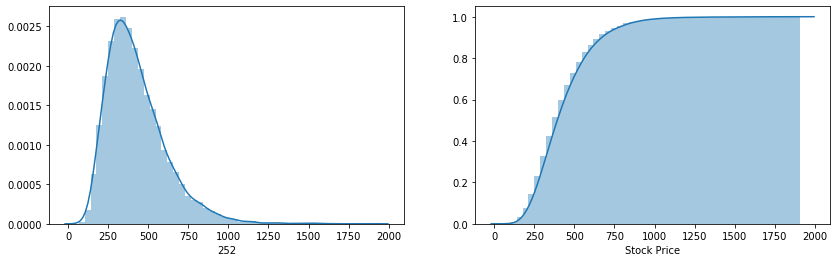

NVDA
Days: 252
Expected Value: $427.09
Return: 24.46%
Probability of Breakeven: 0.6788
Beta: 1.47
Sharpe: 0.17
CAPM Return: 9.84%


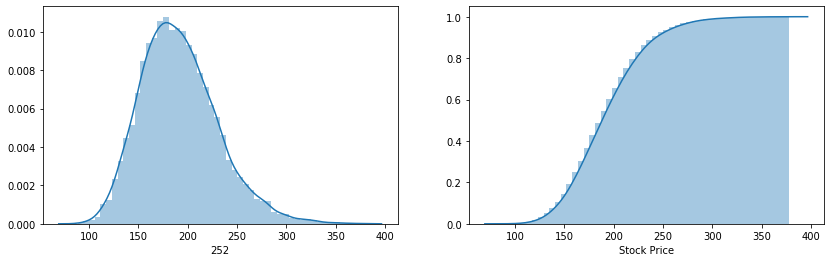

BRK-B
Days: 252
Expected Value: $191.73
Return: 8.92%
Probability of Breakeven: 0.6425
Beta: 0.96
Sharpe: 0.24
CAPM Return: 7.28%


In [31]:
ret_sim_df = monte_carlo(['NVDA','BRK-B'], '2010-1-1', 252, 10000)